# A game of tag

To exemplify the use of the Road Agent framework we shall write a game
of tag simulation.

Agents are bike riders. Tagged bikes -which are faster- seek untagged
riders. If they come close enough to untagged bikes, they tag them! To increase
their chances of catching untagged bikes, they randomly circle nodes with the
**highest** [betweenness centrality](https://en.wikipedia.org/wiki/Betweenness_centrality)
in the street network.

Untagged riders must cross town from point A to point B and back again
continuously. As an evasive strategy untagged bikes route through points with the **lowest** 
[betweeness centrality](https://en.wikipedia.org/wiki/Betweenness_centrality) in
the street network.

## The environment

Agent Based simulations usually involve interaction with the
environment. We shall use the [OSMNX](https://pypi.org/project/OSMnx/)
library to download a street network, and use nodes from it to 
set points and destinations for agents.

In [1]:
import osmnx as ox
%matplotlib inline
import matplotlib.pyplot as plt
ox.config(log_file=True, log_console=True, use_cache=True)
from LatLon import LatLon

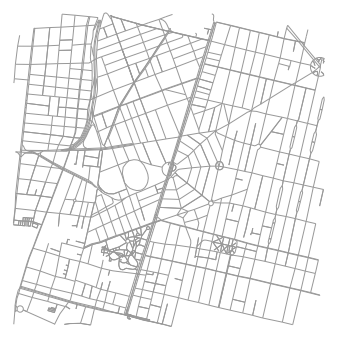

In [2]:
# grab a square somewhere in Mexico City
G = ox.graph_from_point((19.3838,-99.1758), distance=1200)
fig, ax = ox.plot_graph(G, node_size=0)

# you could also use this method and run a simulation on your home town. Try it!
#G = ox.graph_from_place('Tzintzuntzan, Michoacan, Mexico', network_type='bike')

## Set bases A and B 

Untagged bikes will run among these, to and fro.

In [3]:
# find westernmost node to make it base A
x_min = min([G.nodes[osmid]['x'] for osmid in G.nodes])
base_A = [G.nodes[osmid] for osmid in G.nodes if G.nodes[osmid]['x'] == x_min][0]
base_A_point = LatLon(base_A['y'], base_A['x'])
base_A

{'osmid': 4183674558, 'x': -99.1871936, 'y': 19.3801201}

In [4]:
# find easternmost node to make it base B
x_max = max([G.nodes[osmid]['x'] for osmid in G.nodes])
base_B = [G.nodes[osmid] for osmid in G.nodes if G.nodes[osmid]['x'] == x_max][0]
base_B_point = LatLon(base_B['y'], base_B['x'])
base_B

{'osmid': 4074023177, 'x': -99.1643849, 'y': 19.3915158}

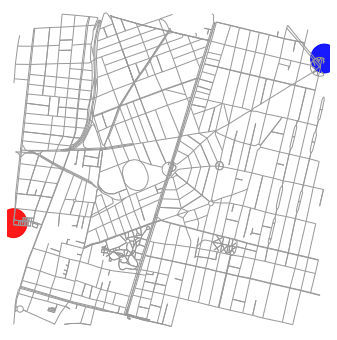

In [5]:
fig, ax = ox.plot_graph(G, node_size=0, show=False, close=False)
ax.add_artist(plt.Circle((base_A['x'], base_A['y']), 0.001, color='red', alpha=0.9))
ax.add_artist(plt.Circle((base_B['x'], base_B['y']), 0.001, color='blue', alpha=0.9))

plt.show()

## Low betweenness centrality nodes

Crate a list of low betweenness centrality nodes. We'll grab items from here to include in the untagged routes, according to our evasion strategy.

In [6]:
lower_betweeness_threshold = 0.05

import networkx as nx
from LatLon import LatLon
import random
import numpy as np

low_btw = [LatLon(G.node[osmid]['y'], G.node[osmid]['x']) 
           for osmid, btw in nx.betweenness_centrality(G).iteritems()
           if btw > 0 and btw <= lower_betweeness_threshold]

print len(low_btw), "low betweenness nodes, out of a total of ", len(G.node)

# a random node from this dict
random.choice(low_btw)

969 low betweenness nodes, out of a total of  1162


Latitude 19.3854672, Longitude -99.1830157

## High betweeness centrality nodes

Tagged agents will roam the most central nodes. Victims are shure to come by!

In [7]:
high_betweeness_threshold = 0.1

high_btw = [LatLon(G.node[osmid]['y'], G.node[osmid]['x']) 
            for osmid, btw in nx.betweenness_centrality(G).iteritems()
            if btw >= high_betweeness_threshold]

# there's just a few of them
high_btw

[Latitude 19.3828092, Longitude -99.1760359,
 Latitude 19.3831326, Longitude -99.1759217,
 Latitude 19.3798543, Longitude -99.1778753,
 Latitude 19.3861117, Longitude -99.1749694,
 Latitude 19.3901315, Longitude -99.1736594,
 Latitude 19.3806848, Longitude -99.1767155,
 Latitude 19.3804975, Longitude -99.1767748,
 Latitude 19.3898697, Longitude -99.1783449,
 Latitude 19.3801415, Longitude -99.1768934,
 Latitude 19.3862654, Longitude -99.1749204,
 Latitude 19.3801962, Longitude -99.1768752,
 Latitude 19.3766207, Longitude -99.1781815,
 Latitude 19.3803072, Longitude -99.1763829,
 Latitude 19.3765946, Longitude -99.1780675,
 Latitude 19.3820079, Longitude -99.1786843]

## The Bike class

Now we extend the Agent class to create our bikes. We'll write methods for both modes of play: tagged and untagged.


In [8]:
from road_agent import Agent

class Bike(Agent):

    def dest_high_btw_node(self):
        """
        tagged agents will ride to high betweenness nodes
        to increase their chances of catching untagged agents
        """
        self.set_destination(random.choice(high_btw))
        self.update_route()
    
    def set_mode(self, mode):
        if mode == 'tagged':
            self.mode = 't'
            # tagged bikes go faster
            self.speed = random.uniform(4, 6)  # speed given in m/s
            # just got tagged? select random destination
            self.dest_high_btw_node()
        else:
            self.mode = 'u'
            self.speed = random.uniform(3, 4)
            # choose a route through low betweeness node
            b.update_route([random.choice(low_btw), ])
            
    def tag_nearby_agents(self, bikes):
        """
        seek bikes close to me, tag them!
        """
        for b in bikes:
            if self.distance_to(b.point()) < self.speed and b.mode == 'u':
                print "at t=%s agent %s tagged %s!" % (t, id(self), id(b))                
                b.set_mode('tagged')        

    def tagged_step(self):
        # Here we use the global variable N which contains the whole bike population
        # 'cause this is a tutorial and it is useful to keep it simple.
        # But you might use a database with useful queries and such
        # by mixing in the Agent class with an ORM
        self.tag_nearby_agents(N)

        # choose a destination
        if self.got_there():
            self.dest_high_btw_node()
        else:
            self.step()
        
    def untagged_step(self):
        if self.got_there():
            # got to a base? turn around and head back to the one you came from!
            if self.destination() == base_A_point:
                self.set_destination(base_B_point)
            elif self.destination() == base_B_point:
                self.set_destination(base_A_point)
            
            # but go through a low betweenness centrality node, to try and evade taggers
            self.update_route([random.choice(low_btw), ])
        else:
            self.step()
    
    def play_tag(self):
        if self.mode == 't':
            self.tagged_step()
        elif self.mode == 'u':
            self.untagged_step()    

### Simulation initialization

In [9]:
number_of_bikes = 20
simulation_steps = 2400

# log population sizes
tagged_pop = np.zeros(simulation_steps)
untagged_pop = np.zeros(simulation_steps)

# create a bike population with a list comprehension
N = [Bike(point=base_A_point, dest=base_B_point)  # all bikes start at base A, heading for B
     for n in range(number_of_bikes)]

for b in N:
    # set them all in the untagged mode
    b.set_mode('untagged')
    # let each agent keep a log of its trail
    b.trail = []
    
# add one tagged bike!
point, dest = random.sample(high_btw, 2)

tagged_bike = Bike(point=point, dest=dest)
tagged_bike.set_mode('tagged')
tagged_bike.trail = []

N.append(tagged_bike)

### Run simulation

In [10]:
for t in range(simulation_steps):
    # update population logs
    tagged_pop[t] = len([1 for b in N if b.mode == 't'])
    untagged_pop[t] = len([1 for b in N if b.mode == 'u'])

    for b in N:
        b.play_tag()
        # make a log entry every 100 steps
        if t % 100 == 0:
            b.trail.append({'point': (float(b.point().to_string()[1]),
                                      float(b.point().to_string()[0])),
                            'mode': b.mode})

at t=440 agent 140434198413112 tagged 140434204496240!
at t=1147 agent 140434198413112 tagged 140434205036840!
at t=2191 agent 140434204496240 tagged 140434205039792!


### Plot population dynamics

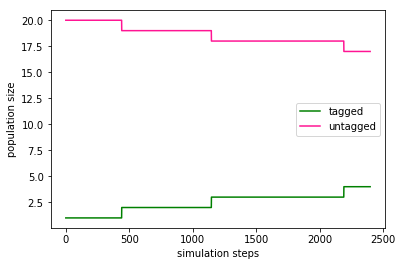

In [11]:
fig = plt.figure()
ax = fig.gca()
plt.plot(range(simulation_steps), tagged_pop, color='green', label='tagged')
plt.plot(range(simulation_steps), untagged_pop, color='deeppink', label='untagged')
ax.set_ylabel('population size')
ax.set_xlabel('simulation steps')
ax.legend()
plt.show()

### Plot some frames

Tagged agents are green, untagged agents are pink.

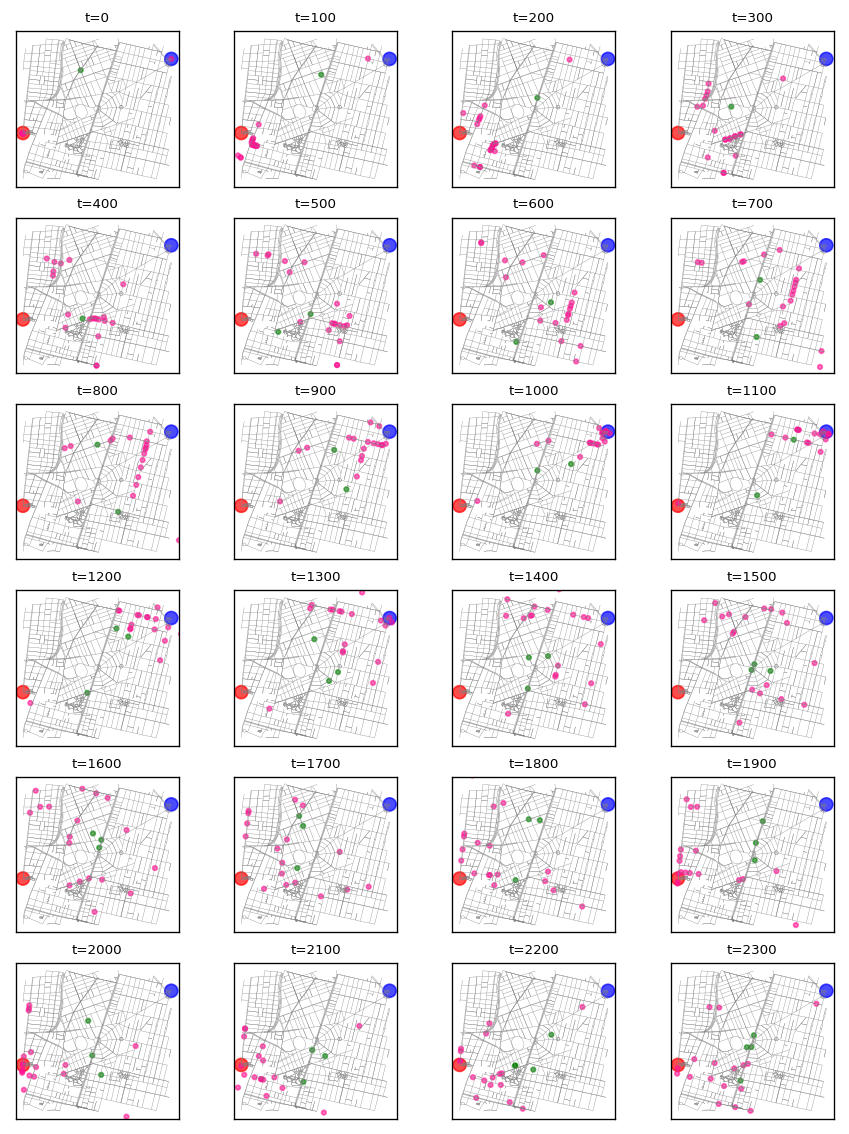

In [12]:
# get edges of street network into geodataframe, for easier re-use
gdf = ox.plot.graph_to_gdfs(G, nodes=False)

fig, axes = plt.subplots(nrows=6, ncols=4,
                         sharex='all', sharey='all',
                         figsize=(9, 12), dpi=120)

axes = axes.flat
for ax, t in zip(axes, range(24)):
    # plot streets
    gdf.plot(ax=ax, linewidth=0.2, color="grey")
    # mark bases
    ax.add_artist(plt.Circle((base_A['x'], base_A['y']), 0.001, color='red', alpha=0.7))
    ax.add_artist(plt.Circle((base_B['x'], base_B['y']), 0.001, color='blue', alpha=0.7))
    # mark agent locations at current timestep
    for b in N:
        if b.trail[t]['mode'] == 'u':
            color = 'deeppink'
        elif b.trail[t]['mode'] == 't':
            color = 'green'
        ax.add_artist(plt.Circle(b.trail[t]['point'], 0.00035, color=color, alpha=0.6))
    ax.set_title("t=%s" % (t*100), fontdict={'fontsize': 8})
    ax.set_xticks([]) 
    ax.set_yticks([]) 

plt.show()